In [1]:
import warnings

import pooch

# don't need to show warning about setting up optimizer
warnings.filterwarnings(
    "ignore",
    message="You will need to call setup",
    category=UserWarning,
)

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`ps_limitations.ipynb`**!

:::

(ps-limitations)=
# Portilla-Simoncelli Model Limitations

## Usage limitations

The Portilla-Simoncelli model only operates on images whose height and width can be divided by 2 `n_scales` <!-- skip-lint --> times (where `n_scales` <!-- skip-lint --> is one of the initialization arguments for {class}`~plenoptic.simulate.models.portilla_simoncelli.PortillaSimoncelli`). This is because the model computes [cross-scale correlations](ps-cross-scale) by recursively downsampling the input image by a factor of 2, then upsampling to compare representations at adjacent scales. For this to work properly, the image dimensions must survive repeated halving and doubling without changing size. For example, if we start with an image of size `(1, 1, 255, 255)`, downsampling by a factor of 2 we will produce an image of size `(1, 1, 128, 128)`, but upsampling that back produces a size of `(1, 1, 256, 256)` --- a mismatch!

To avoid this issue, use images whose height and width are divisible by 2 the requisite number of times. If your image doesn't meet this requirement, you can:
- Crop the image (e.g., using {func}`plenoptic.tools.signal.center_crop`).
- Pad the image (e.g., using {func}`torch.nn.functional.pad`).
- Upsample the image (e.g., using {func}`torch.nn.functional.interpolate`).
- Downsample the image (e.g., using {func}`torch.nn.functional.interpolate`).

## Synthesis limitations

Not all texture model metamers look perceptually similar to humans. {cite:alp}`Portilla2000-param-textur` figures 17 and 18 present two classes of failures: "inhomogeneous texture images not usually considered to be 'texture'" (such as human faces, fig. 17) and some simple hand-drawn textures (fig. 18), many of which are simple geometric line drawings.

Note that for these examples, we were unable to locate the original images, so we present examples that serve the same purpose.

In [2]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload 2

# We need to download some additional images for this notebook.
IMG_PATH = po.data.fetch_data("portilla_simoncelli_images.tar.gz")
CACHE_DIR = po.data.fetch_data("ps_regression.tar.gz")
# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

  0%|                                  | 1.02k/51.3M [00:00<11:05:55, 1.28kB/s]

:::{admonition} This notebook retrieves cached synthesis results
:class: warning dropdown
This notebook contains many metamers and, while any one synthesis operation does not take too long, all of them combined result in a lengthy notebook. Therefore, instead of performing synthesis in this notebook, we have cached the result of most of these syntheses online and only download them for investigation.

Additionally, while you can normally call {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` again to pick up where we left out, the cached version of the results shown here discarded the optimizer's state dict (to reduce the size on disk). Thus, calling `met.synthesize(100)` with one of our cached and loaded metamer objects **will not** give the same result as calling `met.synthesize(200)` with a new metamer object initialized as shown in this notebook.

:::

In [3]:
img = po.data.einstein().to(DEVICE).to(torch.float64)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
# to avoid running so many syntheses in this notebook, we load a cached version. see the
# following admonition for how to run this yourself
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / "ps_basic_synthesis_einstein.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

Here we can see that the texture model fails to capture anything that makes this image look "portrait-like": there is no recognizable face or clothes in the synthesized metamer. As a portrait is generally not considered a texture, this is not a model *failure* per se, but does demonstrate the limits of this model.

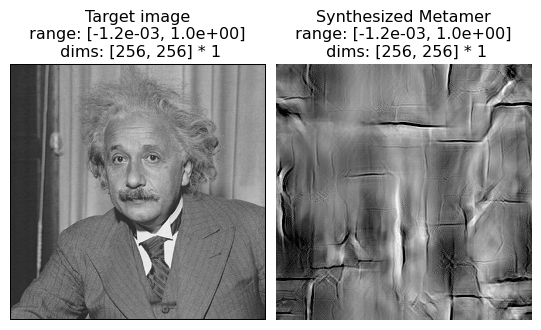

In [4]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized Metamer"],
    vrange="auto1",
);

:::{admonition} Portilla-Simoncelli metamers with **non-texture** targets
:class: warning

When synthesizing Portilla-Simoncelli metamers for texture target images (e.g., as in [](ps-examples)), we have a pretty good sense of what successful metamer synthesis should look like perceptually: a natural image that belongs to the same texture class as the target, which is not identical to the original image.

However, the above demonstrates that it is difficult to predict what a Portilla-Simoncelli metamer will look like for a **non-texture** target image. Therefore, one must be careful to ensure that their optimization procedure has converged to a low enough loss to be interpretable and that optimization has not failed because e.g., it got stuck in a local minimum. See [](ps-optimization) for further discussion.

:::

In the following example, we see the model metamer fails to reproduce the randomly distributed oriented black lines on a white background: in particular, several lines are curved and several appear discontinuous. From the paper: "Although a texture of single-orientation bars is reproduced fairly well (see Fig. 12), the mixture of bar orientations in this example leads to the synthesis of curved line segments. In general, the model is unable to distinguish straight from curved contours, except when the contours are all of the same orientation."

In [5]:
img = po.tools.load_images(IMG_PATH / "fig18a.png")
img = img.to(DEVICE).to(torch.float64)

# reuse the model and loss from above, only the image has changed.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / "ps_basic_synthesis_fig18a.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

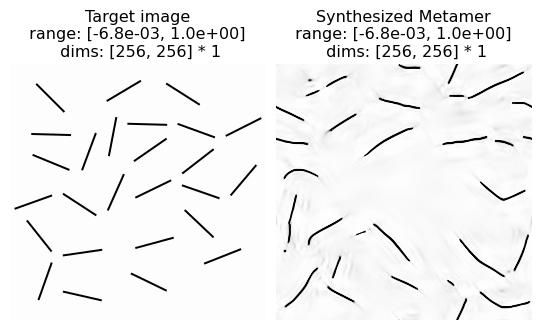

In [6]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized Metamer"],
    vrange="auto1",
);